# HoWiE Big Bash Predictor

The HoWiE Big Bash Predictor is a Logistic Regression Model that aims to predict the outcomes of big bash games. In the notebook we'll step through the code and compare our predictions against the 2017/2018 season before making predictions on the first round of the 2018/2019 season.

I've spent the better half of the last month scrapping together data from multiple sources. In the end I sourced the data for the seasons ranging from the beginning of the big bash to the 2017/2018 season from cricsheet.org. The website provides ball by ball data in CSV format which made this model possible. So a big shout out to the owners of the site.

Now let's get onto the model!

Firstly import the necessary modules and load in our data

In [1]:
from feature_creation import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn import svm, linear_model
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from functools import reduce
raw_df = pd.read_csv('all_bbl_games_current.csv')
odds_df = pd.read_csv('2018_odds.csv')
feature_df = pd.read_csv('differential_df.csv').drop('Unnamed: 0', axis = 1)


To start let's have a look at the game to game data


In [2]:
raw_df.tail()

,Unnamed: 0,Match_ID,Date,Team,Opponent,Venue,At_Home,Won_Toss,Batted_First,f_Runs_For,f_Wickets_Lost,f_Overs_Batting,f_Runs_Against,f_Wickets_Taken,f_Overs_Bowled,Result
451,451,231,1/02/2018,Hobart Hurricanes,Perth Scorchers,Optus Stadium,0,0,1,210,4,20.0,139,10,17.5,Hobart Hurricanes
452,452,232,2/02/2018,Adelaide Strikers,Melbourne Renegades,Adelaide Oval,1,1,1,178,5,20.0,177,4,20.0,Adelaide Strikers
453,453,232,2/02/2018,Melbourne Renegades,Adelaide Strikers,Adelaide Oval,0,0,0,177,4,20.0,178,5,20.0,Adelaide Strikers
454,454,233,4/02/2018,Adelaide Strikers,Hobart Hurricanes,Adelaide Oval,1,1,1,202,2,20.0,177,5,20.0,Adelaide Strikers
455,455,233,4/02/2018,Hobart Hurricanes,Adelaide Strikers,Adelaide Oval,0,0,0,177,5,20.0,202,2,20.0,Adelaide Strikers


# Looking at our Dataset
The main features that we have are runs, wickets and overs. Let's plot these features against the team to see what features reflect our teams.

In [3]:
avg_df = pd.DataFrame()
f_names = [col for col in raw_df if col.startswith('f_')]
for f_name in f_names:
    temp_df = raw_df.groupby('Team')[f_name].mean()
    avg_df[f_name] = temp_df
avg_df

,f_Runs_For,f_Wickets_Lost,f_Overs_Batting,f_Runs_Against,f_Wickets_Taken,f_Overs_Bowled
Team,,,,,,
Adelaide Strikers,153.428571,6.357143,19.071429,151.571429,6.517857,18.837500
Brisbane Heat,158.745455,6.581818,18.921818,157.054545,5.672727,18.572727
Hobart Hurricanes,162.200000,6.290909,19.367273,161.454545,6.036364,18.750909
Melbourne Renegades,153.298246,5.859649,18.663158,156.842105,6.140351,19.171930
Melbourne Stars,153.620690,5.879310,18.606897,150.155172,6.155172,18.644828
Perth Scorchers,150.546875,5.359375,18.498438,143.921875,6.531250,18.695313
Sydney Sixers,145.948276,6.206897,18.534483,147.896552,5.724138,18.577586
Sydney Thunder,142.811321,6.226415,18.458491,153.150943,5.773585,18.833962


Cool we've got our averages over the entire seasons. We can see that the Hurricanes average the most amount of runs with brisbane heat in a close second and that the perth scorchers average the most amount of wickets in a game.

Let's make some plots to better visualise and understand our data.
Firstly we'll look at the distribution of runs scored and wickets taken per team over the history of the BBL.

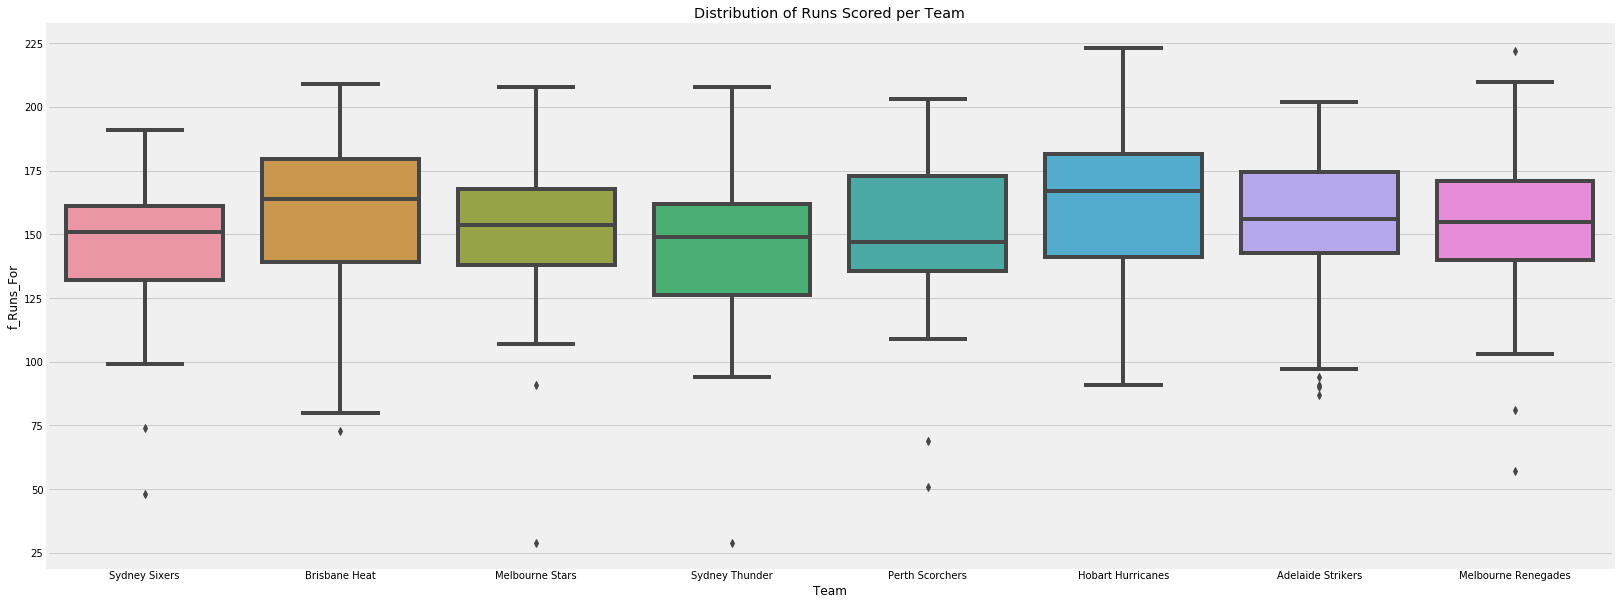

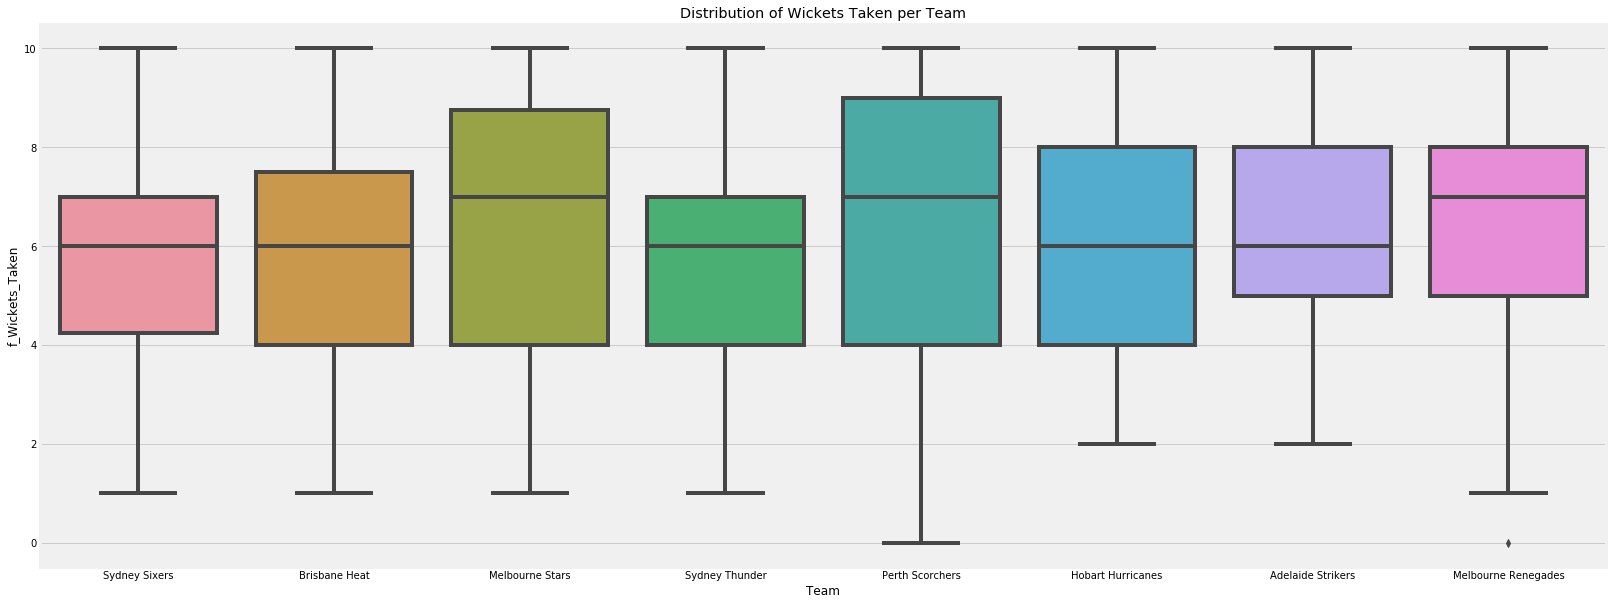

In [4]:
plt.subplots(figsize = (25,10))
plt.title('Distribution of Runs Scored per Team')
sns.boxplot(x = 'Team', y = 'f_Runs_For', data=raw_df)

plt.subplots(figsize = (25,10))
plt.title('Distribution of Wickets Taken per Team')
sns.boxplot(x = 'Team', y = 'f_Wickets_Taken', data=raw_df)


We can see that a team like Hobart seems to score more runs than a team such as the sydney thunder. If we also look at the wickets taken we can see that sydney thunder also are at the bottom end of the spectrum when it comes to taking wickets. This would lead us to believe that the Sydney Thunder might struggle in the competition.

The next thing I want to do is see if there is any correlation between some of our variables. To do this we can use a correlation matrix and wrap it in the sns heatmap function.

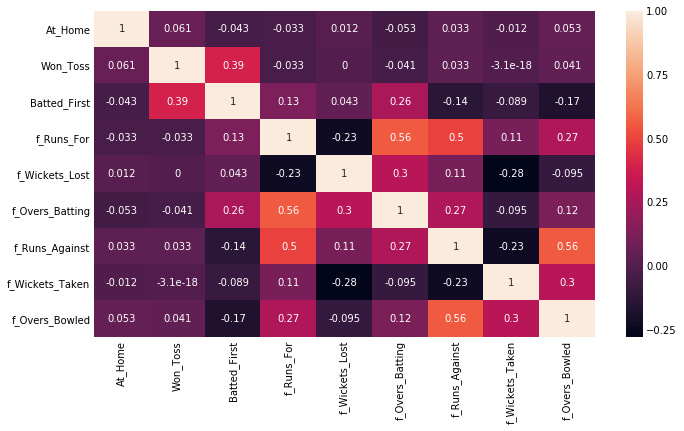

In [5]:
plt.figure(figsize=(10,6)) #manage the size of the plot
sns.heatmap(raw_df.drop(['Match_ID','Unnamed: 0'],axis = 1).corr(),annot=True) #df.corr() makes a correlation matrix and sns.heatmap is used to show the correlations heatmap
plt.show()

Things can see that that have a strong correllation are the runs to overs. This makes sense... The more overs you bat the more runs you're likely to.

The last thing I want to do is generate ELO scores for each of our teams and add this as a feature. If you're unsure what the ELO ranking system is have a quick look on wikipedia: https://en.wikipedia.org/wiki/Elo_rating_system. The system was originally invented to rank chess players but is now widely used on many sports. 

I have adapted the ELO function from  the Betfair Data scientists. You can find their work on their github here: https://github.com/betfair-datascientists/predictive-models
If you were planning on giving ML a go especially with sport these guys have a couple tutorials which will get you underway.

Okay now let's generate our ELO scores.

In [6]:
elos, probs, elo_dict = elo_applier(raw_df,40,50)

for team in sorted(elo_dict,key=elo_dict.get)[::-1]:
    print(team, elo_dict[team])

Perth Scorchers 1639.72568598206
Adelaide Strikers 1620.8643160075526
Sydney Sixers 1524.1519701400643
Melbourne Renegades 1504.296849097369
Hobart Hurricanes 1482.1173843364754
Melbourne Stars 1453.7533317822358
Brisbane Heat 1425.6088647671154
Sydney Thunder 1414.3592057305902


Our ELO looks pretty good. We've got the most successful BBL team the Perth Scorchers at the top of the table with the winners of the big bash in second. Down the bottom we have the Sydney Thunder who have statistically been the worst team in the BBL.

# Predicting the 2017/2018 Seasons
Now that we've been introduced to our data let's see if we can make a model that can predict the outcome of the matches in the 2017/2018 season. What we need to do is split our data into training and test data, pick a ML model, tune our model and predict the outcomes.

Let's split our data into

train: seasons from beginning to 2016/2017

test: season 2017:2018

and scale it for our model

In [7]:
f_col = [col for col in feature_df if col.startswith('f_')]
#Create test Dataset
test_y = feature_df.loc[181:,'Did_Home_Win']
test_x = feature_df.loc[181:, ['Match_ID'] + f_col]
#Create train Dataset
train_y = feature_df.loc[:181,'Did_Home_Win']
train_x= feature_df.loc[:181,['Match_ID'] + f_col]

scaler = StandardScaler()
test_x[f_col] = scaler.fit_transform(test_x[f_col])
train_x[f_col] = scaler.fit_transform(train_x[f_col])

Now that we have our training / test split we need to pick a model. I spent a fair bit of time on this and ended up choosing logistic regression for HoWiE. What we should first do is try the logistic regression model without tuning our parameters and see what accuracy we get.

In [8]:
model = linear_model.LogisticRegression()
model.fit(train_x, train_y)
predict = model.predict(test_x)
acc = (predict == test_y).mean()*100
print("Accuracy without tuning for 2017/2018 season: {:.2f}%".format(acc))

Accuracy without tuning for 2017/2018 season: 57.14%


Alright! So without tuning our logistic regression model we achieve an accuracy of 57.14%. We're already doing better than a 50/50 guess so we must be doing something right. 
Now we should tune our model to see if we can improve this accuracy.

In [9]:
def log_regression_param_selection(train_x, train_y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1 ,10, 100, 1000]
    param_grid = {'C': Cs}
    
    grid_search = GridSearchCV(linear_model.LogisticRegression(), param_grid, cv = nfolds)
    grid_search.fit(train_x, train_y)
    print(grid_search.best_params_)
    return grid_search.best_params_

best_params_log = log_regression_param_selection(train_x, train_y,3)

{'C': 0.1}


Okay so our best C value is 0.1 lets see if this improves our accuracy.

In [10]:
best_params_log = log_regression_param_selection(train_x,train_y,3)
model = linear_model.LogisticRegression(**best_params_log)
model.fit(train_x,train_y)
predict = model.predict(test_x)
acc = (predict == test_y).mean() * 100
print("Our accuracy in predicting the 2017/2018 season after tuning is: {:.2f}%".format(acc))

{'C': 0.1}
Our accuracy in predicting the 2017/2018 season after tuning is: 61.90%


Nice, we've improved our accuracy to 61.9%. Now that we have a model that has been tuned and is predicting 62% of games correctly my inner Aussie is shouting at me to see if we can beat the bookies.

# Taking on the Bookies
To take on the bookies we need to make odds of our own. Luckly the sklearn module gives us a probability funcition we can use.

In [11]:
x = model.predict_proba(test_x) ** -1
x

array([[2.10356446, 1.90615459],
       [1.51862396, 2.92817935],
       [1.7431356 , 2.34564944],
       [1.82554494, 2.2113211 ],
       [1.57818488, 2.72955058],
       [1.55009291, 2.81787473],
       [2.36037716, 1.73509026],
       [1.48211522, 3.07419299],
       [1.79838549, 2.25252777],
       [1.37192841, 3.6886895 ],
       [1.47951544, 3.08543859],
       [1.96786734, 2.03319945],
       [2.4452966 , 1.6918995 ],
       [1.96976982, 2.03117254],
       [1.68304314, 2.46403638],
       [1.40461073, 3.47151133],
       [1.69026567, 2.44871757],
       [1.84149497, 2.18836123],
       [1.62969387, 2.58807326],
       [1.58902425, 2.69772296],
       [2.48156439, 1.67496223],
       [2.39554804, 1.71656437],
       [2.40163666, 1.71345166],
       [1.47521941, 3.10429115],
       [1.79943   , 2.25089126],
       [1.87736425, 2.13977747],
       [1.65421838, 2.52854158],
       [1.49235968, 3.0310355 ],
       [1.98988619, 2.01021715],
       [2.58439309, 1.6311565 ],
       [1.

These are our predicted odds. The left hand side is the odds of the away team winning, the home team is the right hand column. The above might be a little confusing so to make it more readable I've created a dataframe of the bookies odds and our odds along with the results from the game. Let's have a look.

In [12]:
### Review the Model
Review_df = feature_df.loc[181:,['Date','Home_Team','Away_Team','Result','Did_Home_Win']]
Review_df['Prediction'] = predict
Review_df = pd.merge(Review_df, odds_df, on = ['Date', 'Home_Team', 'Away_Team'])
Review_df['Modelled_Home_Odds'] = x[:,1]
Review_df['Modelled_Away_Odds'] = x[:,0]
Review_df.tail()

,Date,Home_Team,Away_Team,Result,Did_Home_Win,Prediction,Home_Odds,Away_Odds,Modelled_Home_Odds,Modelled_Away_Odds
37,27/01/2018,Brisbane Heat,Melbourne Renegades,Melbourne Renegades,0,1,1.65,2.25,1.820147,2.219293
38,27/01/2018,Melbourne Stars,Hobart Hurricanes,Melbourne Stars,1,0,2.43,1.57,2.528322,1.654312
39,1/02/2018,Perth Scorchers,Hobart Hurricanes,Hobart Hurricanes,0,1,1.41,2.95,1.475268,3.104074
40,2/02/2018,Adelaide Strikers,Melbourne Renegades,Adelaide Strikers,1,1,1.79,2.03,1.731424,2.367196
41,4/02/2018,Adelaide Strikers,Hobart Hurricanes,Adelaide Strikers,1,1,1.84,1.97,1.727588,2.374404


Here we can compare how we went against the actual season. If the Did_Home_Win column matches the Prediction column then we correctly predicted that game. You can also see the odds we calculate vs the odds offered by the bookies for each game.

To see if we could make any model off HoWiE I've created a simple betting process. It is as follows:
If our predicted odds are < the bookies odds we will make a $50 bet.

Let's see how we do.

In [13]:
#Simple Put $50 On Who I think Will win
kitty = []
outlay = 0
bet = 50
for index, row in Review_df.iterrows():

    Prediction = row['Prediction']
    Did_Home_Win = row['Did_Home_Win']
    
    if (Prediction == Did_Home_Win):
        if(Prediction == 1 and row['Home_Odds'] > row['Modelled_Home_Odds']):
            win = row['Home_Odds'] * bet - bet
            outlay1 = bet
        elif(Prediction == 0 and row['Away_Odds'] > row['Modelled_Away_Odds']):
            win = row['Away_Odds'] * bet - bet
            outlay1 = bet
        else:
            continue
    elif (Prediction != Did_Home_Win):
        if(Prediction == 1 and row['Home_Odds'] > row['Modelled_Home_Odds']):
            win = -bet
            outlay1 = bet
        elif(Prediction == 0 and row['Away_Odds'] > row['Modelled_Away_Odds']):
            win = -bet
            outlay1 = bet
        else:
            continue
    kitty.append(win)
    outlay = outlay+outlay1
print("Money Made: $"+ str(sum(kitty)))
print("Money Outlaid: $"+ str(outlay))


Money Made: $403.0
Money Outlaid: $1600


We had a positive return! We beat the bookies for the 2017/2018 season. Spending a total of $1600 returned $2003 which equates to a ROI of 25%. Let's plot our winnings trend over the season.

Text(0.5,1,'Money Tally over 2017/2018 Season')

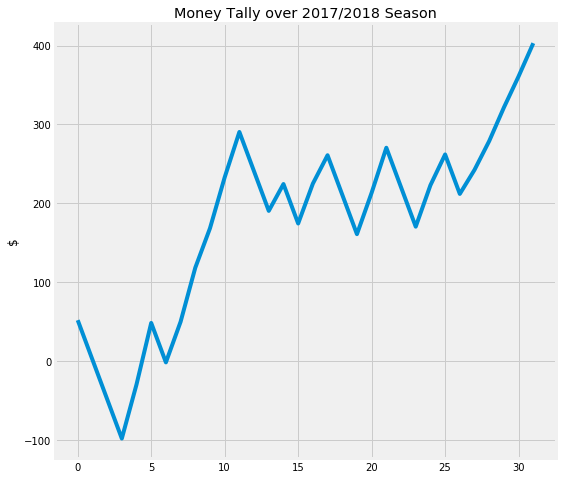

In [14]:
def add_one_by_one(l):
    new_l = []
    cumsum = 0
    for elt in l:
        cumsum += elt
        new_l.append(cumsum)
    return new_l
cumsum = add_one_by_one(kitty)

plt.subplots(figsize = (8,8))
plt.plot(cumsum)
plt.ylabel('$')
plt.title('Money Tally over 2017/2018 Season')

# Tips for Round 1 of 2018/2019 Big Bash
Last thing I want to do is load in the 2018/2019 fixture for the Big Bash and make some predictions. The code below essentially reruns everything we've done above but incorporates the 2017/2018 season into our training data and uses the 2018/2019 fixture as the test data.

In [15]:
##Make a Prediction
def get_df(path):
    df = pd.read_csv(path)
    
    return df    

fixture = get_df('next_week.csv')
fixture_list = fixture.Match_ID.tolist()
current_df = get_df('all_bbl_games_current.csv')
new_df = current_df.append(fixture).reset_index(drop=True)
new_df1 = create_features_df(new_df)
f_col = [col for col in new_df1 if col.startswith('f_')]
train_df = new_df1[~new_df1.Match_ID.isin(fixture.Match_ID)].dropna()
train_x = train_df.drop(columns=['Did_Home_Win']).loc[:,f_col]
train_y = train_df.Did_Home_Win

next_round_x = new_df1[new_df1.Match_ID.isin(fixture.Match_ID)].loc[:,f_col]

##
#Create test Dataset
scaler = StandardScaler()
next_round_x[f_col] = scaler.fit_transform(next_round_x[f_col])
train_x[f_col] = scaler.fit_transform(train_x[f_col])
##
best_params_log = log_regression_param_selection(train_x,train_y,3)
model = linear_model.LogisticRegression(**best_params_log)
model.fit(train_x,train_y)
predict = model.predict(next_round_x)
score = model.score(train_x,train_y)
print('Overall Accuracy for All Seasons is : ' + str(score*100) + '%')
x = model.predict_proba(next_round_x) ** -1

### Review the Model
Review_df = new_df1[new_df1.Match_ID.isin(fixture.Match_ID)].loc[:,['Date','Home_Team','Away_Team']]
Review_df['Prediction'] = predict
#Review_df = pd.merge(Review_df, odds_df, on = ['Date', 'Home_Team', 'Away_Team'])
Review_df['Modelled_Home_Odds'] = x[:,1]
Review_df['Modelled_Away_Odds'] = x[:,0]


{'C': 0.1}
Overall Accuracy for All Seasons is : 59.375%


C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


Let's Review our predicitons for the first 5 games of the round

In [16]:
Review_df

,Date,Home_Team,Away_Team,Prediction,Modelled_Home_Odds,Modelled_Away_Odds
228,19/12/2018,Brisbane Heat,Adelaide Strikers,0,2.556347,1.642530
229,20/12/2018,Melbourne Renegades,Perth Scorchers,0,3.263365,1.441820
230,21/12/2018,Sydney Thunder,Melbourne Stars,0,2.299748,1.769380
231,22/12/2018,Sydney Sixers,Perth Scorchers,1,1.750431,2.332567
232,22/12/2018,Brisbane Heat,Hobart Hurricanes,1,1.507606,2.970033


So from our model we are predicting:

1.Adelaide Strikers to beat Brisbane Heat @ $1.64

2.Perth Scorchers to beat Melbourne Renegades @ $1.33

3.Melbourne Stars to beat Sydney Thunder @ $1.81

4.Sydney Sixers to beat Perth Scorchers @ $1.75

5.Brisbane Heat to beat Hobart Hurricanes @ $1.42



# Thanks